In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import pickle
import json
import cv2
import re

In [2]:
tf.test.is_gpu_available()

True

In [3]:
# make image dataloader using flow_from_dataframe
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# load data to extract labels
data_dir = '../facebook_challenge_data/'
model_dir = 'models/'

# load data and print sizes
def get_dict(path):
    jsonl_content = open(path, 'r').read()
    data = [json.loads(jline) for jline in jsonl_content.split('\n')]
    return {datum['id'] : datum for datum in data}


train_dict = get_dict(data_dir + 'train.jsonl')
val_dict = get_dict(data_dir + 'dev.jsonl')
test_dict = get_dict(data_dir + 'test.jsonl')

print(len(train_dict))
print(len(val_dict))
print(len(test_dict))

8500
500
1000


In [4]:
# custom data generator to handle cropping
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from random import randint # for random cropping

class FBDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_dict, batch_size=32, dim=(299, 299), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.data_dict = data_dict
        self.shuffle = shuffle
        
        # build labels list and id list
        self.id_list = list(self.data_dict.keys())
        self.labels = {ID: self.data_dict[ID]['label'] for ID in self.id_list}
        self.img_list = {ID: self.data_dict[ID]['img'] for ID in self.id_list}
            
        self.on_epoch_end()
        self.classes = [self.labels[self.id_list[i]] for i in self.indexes]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(id_list_temp)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        y = np.empty(len(id_list_temp), dtype=int)

        # Generate data
        for i, ID in enumerate(id_list_temp):
            # Store sample
            X[i,] = self.process_img(data_dir + self.img_list[ID])

            # Store class
            y[i] = self.labels[ID]

        return X, y
    
    def process_img(self, path): # method for getting image
        img = Image.open(path)
        img.load()
        if img.size[0] < img.size[1]: # width greater than height
            wpercent = (self.dim[0]/float(img.size[0]))
            hsize = int((float(img.size[1])*float(wpercent)))
            img = img.resize((self.dim[0],hsize), Image.ANTIALIAS)
        else: # height greater than width
            hpercent = (self.dim[0]/float(img.size[1]))
            wsize = int((float(img.size[0])*float(hpercent)))
            img = img.resize((wsize,self.dim[0]), Image.ANTIALIAS)
            
        data = np.asarray(img, dtype='uint8')
        im = self.augment(data) # apply transformation
        
        
        if im.shape==(self.dim[0], self.dim[1]): im = np.stack((im,)*3, axis=-1) # handle grayscale
        if im.shape == (*self.dim, 4): im = im[:,:,:3] # handle weird case
        
        return im
    
    def augment(self, im): # random crop and random mirror
        
        # random crop
        x_max, y_max = im.shape[0], im.shape[1]
        x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
        im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
        # random mirror
        if randint(0,1): im = np.flip(im, axis=1)
        
        return im


In [5]:
# create data generators
train_gen = FBDataGenerator(data_dict=train_dict,
                          batch_size=16,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

val_gen = FBDataGenerator(data_dict=val_dict,
                          batch_size=16,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

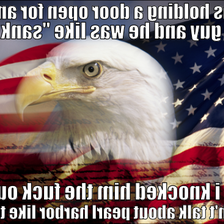

size: (224, 224) label: 1 





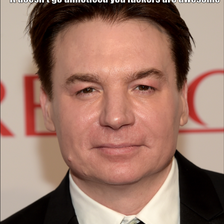

size: (224, 224) label: 0 





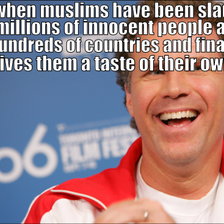

size: (224, 224) label: 1 





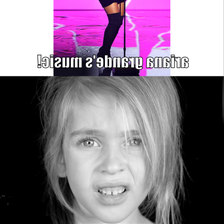

size: (224, 224) label: 0 





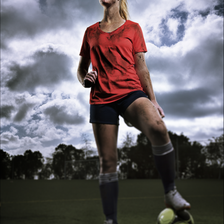

size: (224, 224) label: 0 





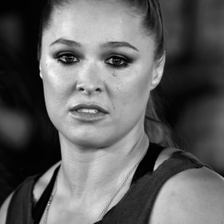

size: (224, 224) label: 0 





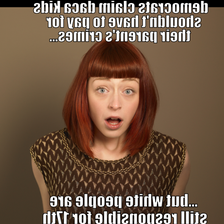

size: (224, 224) label: 0 





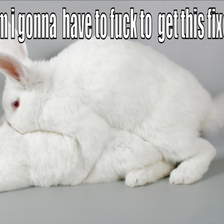

size: (224, 224) label: 0 





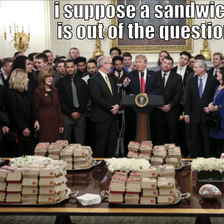

size: (224, 224) label: 0 





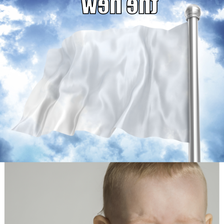

size: (224, 224) label: 0 





In [6]:
# test the image generator

imgs, ys = train_gen.__getitem__(0)

for img, y in list(zip(imgs, ys))[:10]:
    img = Image.fromarray(np.uint8(img), 'RGB')
    display(img)
    print('size:', img.size, 'label:', y, '\n\n\n')

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten

conv_base = tf.keras.applications.resnet.ResNet101(include_top=False, 
                                                        weights='imagenet', 
                                                        input_shape=(224, 224, 3))
for layer in conv_base.layers[:-1]: layer.trainable = False # freeze pretrained layers

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
# model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

optimizer = Adam(lr = 1e-6)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 249,230,721
Trainable params: 206,572,545
Non-trainable params: 42,658,176
_________________________________________________________________
None


In [8]:
# train model

# from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# model = load_model(model_dir + 'cnn_weighted.h5')

mcp_save = ModelCheckpoint(model_dir + 'best_fb_resnet.h5', 
                           save_best_only=True, 
                           monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           save_weights_only=True)

history = model.fit_generator(train_gen,
                    validation_data=val_gen,
                    shuffle=True,
                    epochs=25,
                    callbacks=[mcp_save])


Epoch 1/25
531/532 [============================>.] - ETA: 0s - loss: 0.7888 - accuracy: 0.5737
Epoch 00001: val_loss improved from inf to 0.97680, saving model to models/best_fb_resnet.h5
532/532 [==============================] - 495s 931ms/step - loss: 0.7889 - accuracy: 0.5740 - val_loss: 0.9768 - val_accuracy: 0.5160
Epoch 2/25
531/532 [============================>.] - ETA: 0s - loss: 0.6792 - accuracy: 0.6269
Epoch 00002: val_loss improved from 0.97680 to 0.87532, saving model to models/best_fb_resnet.h5
532/532 [==============================] - 494s 929ms/step - loss: 0.6789 - accuracy: 0.6269 - val_loss: 0.8753 - val_accuracy: 0.4960
Epoch 3/25
531/532 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6490
Epoch 00003: val_loss improved from 0.87532 to 0.83227, saving model to models/best_fb_resnet.h5
532/532 [==============================] - 493s 928ms/step - loss: 0.6522 - accuracy: 0.6489 - val_loss: 0.8323 - val_accuracy: 0.5520
Epoch 4/25
531/532 [

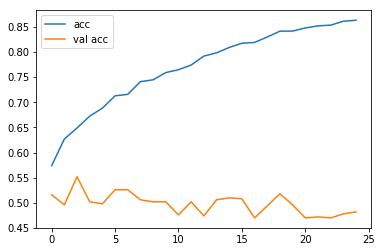

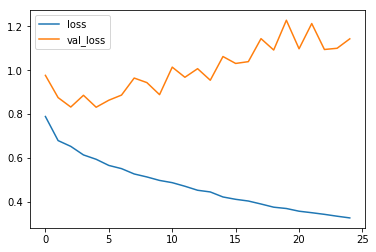

In [9]:
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [10]:
model.load_weights(model_dir + 'best_fb_resnet.h5')

In [11]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import math

y_val = val_gen.classes

# get AUROC
preds = model.predict_generator(val_gen)
print('Test AUROC:', roc_auc_score(y_val, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds>0.5] = 1
preds_bin[preds<=0.5] = 0
print('Test Accuracy:', accuracy_score(y_val, preds_bin))

# get F1
print('Test F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_val, preds_bin, zero_division=1))

Test AUROC: 0.5251359999999999
Test Accuracy: 0.514
Test F1: 0.4172661870503597
Test Precision: 0.5209580838323353
Test Recall: 0.348


In [12]:
for im in os.listdir('../facebook_challenge_data/img/'):
    img = Image.open('../facebook_challenge_data/img/' + im)
    print(img.size)

(240, 400)
(550, 366)
(550, 366)
(800, 800)
(550, 398)
(550, 404)
(550, 366)
(313, 399)
(825, 549)
(297, 400)
(266, 400)
(550, 366)
(550, 412)
(825, 549)
(800, 533)
(550, 366)
(825, 549)
(267, 400)
(550, 367)
(825, 543)
(825, 551)
(825, 538)
(672, 800)
(550, 366)
(825, 549)
(800, 533)
(282, 400)
(305, 400)
(550, 366)
(550, 350)
(531, 800)
(538, 800)
(550, 366)
(550, 366)
(240, 400)
(825, 549)
(825, 549)
(550, 374)
(800, 533)
(543, 800)
(565, 800)
(310, 400)
(800, 532)
(800, 533)
(393, 800)
(825, 575)
(550, 412)
(533, 800)
(550, 366)
(533, 800)
(550, 366)
(800, 533)
(550, 378)
(573, 800)
(550, 366)
(266, 400)
(825, 549)
(550, 365)
(800, 533)
(277, 399)
(266, 400)
(550, 366)
(550, 366)
(550, 366)
(550, 422)
(800, 533)
(294, 400)
(550, 366)
(550, 412)
(800, 523)
(550, 410)
(825, 549)
(696, 800)
(825, 631)
(724, 800)
(533, 800)
(825, 634)
(550, 366)
(550, 366)
(417, 800)
(800, 533)
(550, 366)
(480, 800)
(550, 435)
(300, 400)
(550, 365)
(225, 400)
(533, 800)
(533, 800)
(750, 800)
(800, 531)

(524, 800)
(550, 435)
(825, 659)
(579, 800)
(550, 366)
(591, 800)
(265, 400)
(825, 816)
(825, 592)
(281, 400)
(800, 800)
(800, 533)
(550, 366)
(323, 400)
(312, 800)
(825, 549)
(550, 366)
(550, 366)
(294, 400)
(268, 400)
(696, 800)
(825, 549)
(550, 366)
(300, 400)
(295, 399)
(245, 400)
(825, 549)
(550, 412)
(291, 400)
(825, 549)
(550, 373)
(550, 366)
(702, 800)
(800, 515)
(800, 533)
(550, 366)
(550, 365)
(550, 365)
(825, 549)
(800, 533)
(800, 533)
(825, 576)
(286, 400)
(600, 800)
(285, 400)
(800, 800)
(550, 366)
(800, 533)
(533, 800)
(825, 549)
(825, 546)
(550, 366)
(825, 539)
(825, 549)
(550, 388)
(266, 400)
(825, 407)
(550, 366)
(825, 549)
(825, 549)
(533, 800)
(550, 480)
(825, 547)
(550, 366)
(550, 366)
(825, 549)
(533, 800)
(321, 400)
(267, 400)
(825, 502)
(637, 800)
(268, 400)
(550, 350)
(277, 399)
(642, 800)
(550, 366)
(559, 800)
(267, 400)
(825, 636)
(825, 549)
(825, 549)
(550, 366)
(800, 533)
(550, 366)
(550, 366)
(400, 400)
(266, 400)
(550, 342)
(550, 516)
(550, 365)
(594, 800)

(531, 800)
(306, 400)
(800, 540)
(299, 400)
(800, 533)
(825, 549)
(585, 800)
(331, 400)
(550, 355)
(825, 549)
(561, 800)
(825, 549)
(825, 549)
(188, 400)
(550, 358)
(550, 366)
(623, 800)
(550, 397)
(800, 533)
(534, 800)
(825, 544)
(266, 400)
(800, 800)
(615, 800)
(550, 366)
(616, 800)
(400, 400)
(550, 340)
(641, 800)
(532, 800)
(550, 366)
(302, 400)
(825, 549)
(326, 800)
(550, 366)
(266, 400)
(591, 799)
(533, 800)
(550, 412)
(296, 400)
(825, 621)
(589, 800)
(800, 525)
(347, 400)
(550, 524)
(825, 546)
(269, 400)
(550, 366)
(280, 400)
(266, 400)
(825, 549)
(666, 800)
(247, 400)
(550, 366)
(533, 800)
(240, 400)
(575, 800)
(550, 384)
(825, 549)
(800, 800)
(825, 547)
(519, 800)
(825, 549)
(800, 533)
(395, 400)
(599, 799)
(550, 366)
(825, 573)
(550, 449)
(550, 466)
(467, 800)
(550, 366)
(825, 549)
(298, 399)
(550, 382)
(550, 403)
(825, 549)
(550, 366)
(160, 400)
(550, 366)
(611, 799)
(550, 366)
(550, 366)
(300, 400)
(589, 800)
(550, 366)
(554, 800)
(200, 400)
(550, 359)
(267, 400)
(240, 400)

(267, 400)
(800, 533)
(528, 800)
(550, 366)
(550, 366)
(800, 533)
(266, 400)
(560, 800)
(256, 400)
(550, 366)
(550, 366)
(550, 426)
(550, 373)
(200, 400)
(299, 400)
(825, 547)
(547, 800)
(550, 388)
(661, 800)
(680, 800)
(825, 618)
(390, 400)
(800, 800)
(266, 400)
(550, 388)
(267, 400)
(550, 309)
(825, 549)
(712, 800)
(550, 366)
(825, 515)
(307, 400)
(800, 533)
(550, 365)
(800, 533)
(630, 800)
(550, 366)
(550, 317)
(259, 400)
(572, 800)
(800, 533)
(550, 366)
(299, 400)
(550, 359)
(533, 800)
(800, 537)
(550, 417)
(550, 366)
(550, 366)
(825, 549)
(400, 400)
(599, 800)
(800, 533)
(550, 341)
(550, 366)
(266, 400)
(550, 366)
(533, 800)
(409, 800)
(153, 400)
(550, 366)
(300, 400)
(550, 366)
(283, 400)
(400, 400)
(800, 533)
(800, 546)
(825, 549)
(825, 549)
(533, 800)
(312, 800)
(550, 366)
(550, 366)
(550, 366)
(533, 800)
(825, 549)
(800, 594)
(550, 365)
(800, 628)
(550, 366)
(550, 383)
(550, 366)
(800, 533)
(417, 800)
(825, 549)
(825, 549)
(800, 533)
(550, 365)
(339, 400)
(825, 592)
(800, 533)

(800, 533)
(800, 533)
(550, 380)
(800, 533)
(267, 400)
(550, 367)
(825, 547)
(825, 549)
(550, 532)
(800, 578)
(825, 549)
(508, 800)
(600, 800)
(532, 800)
(533, 800)
(825, 549)
(800, 551)
(267, 400)
(550, 366)
(550, 366)
(550, 372)
(550, 367)
(600, 800)
(825, 618)
(550, 363)
(825, 549)
(550, 366)
(800, 800)
(317, 799)
(267, 400)
(550, 366)
(266, 400)
(800, 544)
(800, 533)
(550, 366)
(591, 800)
(550, 375)
(825, 549)
(410, 800)
(550, 427)
(550, 362)
(266, 400)
(605, 800)
(550, 366)
(800, 533)
(607, 800)
(825, 541)
(550, 366)
(800, 546)
(825, 549)
(265, 399)
(825, 538)
(533, 800)
(550, 366)
(825, 486)
(550, 359)
(306, 400)
(547, 800)
(825, 549)
(550, 379)
(368, 800)
(550, 365)
(298, 400)
(300, 400)
(800, 800)
(825, 592)
(550, 366)
(533, 800)
(267, 400)
(825, 549)
(550, 366)
(550, 366)
(800, 533)
(266, 400)
(550, 426)
(800, 558)
(550, 366)
(800, 533)
(267, 400)
(800, 533)
(550, 366)
(485, 800)
(300, 400)
(550, 364)
(825, 650)
(550, 317)
(267, 400)
(550, 366)
(825, 549)
(566, 800)
(267, 400)

(550, 426)
(825, 520)
(281, 400)
(550, 366)
(300, 400)
(550, 366)
(549, 800)
(550, 366)
(550, 355)
(550, 366)
(265, 400)
(550, 367)
(533, 800)
(712, 800)
(550, 398)
(825, 559)
(550, 403)
(550, 366)
(609, 800)
(550, 426)
(600, 800)
(825, 549)
(825, 547)
(550, 366)
(449, 800)
(800, 533)
(302, 400)
(550, 366)
(550, 392)
(550, 366)
(550, 366)
(550, 366)
(550, 366)
(267, 400)
(643, 800)
(550, 366)
(550, 345)
(572, 800)
(800, 533)
(550, 345)
(267, 400)
(825, 549)
(365, 400)
(800, 533)
(643, 800)
(550, 413)
(825, 559)
(266, 400)
(550, 366)
(550, 357)
(825, 549)
(825, 549)
(825, 549)
(825, 549)
(228, 400)
(400, 400)
(800, 533)
(550, 382)
(533, 800)
(550, 366)
(825, 549)
(825, 728)
(422, 800)
(825, 549)
(800, 533)
(550, 366)
(420, 800)
(533, 800)
(825, 549)
(800, 533)
(800, 555)
(825, 549)
(550, 365)
(825, 549)
(800, 800)
(550, 366)
(564, 800)
(550, 346)
(550, 366)
(825, 549)
(550, 366)
(800, 533)
(452, 800)
(825, 715)
(534, 800)
(800, 533)
(825, 520)
(550, 366)
(825, 549)
(825, 586)
(825, 551)

(550, 366)
(550, 420)
(550, 333)
(550, 412)
(800, 600)
(550, 364)
(291, 400)
(550, 366)
(825, 549)
(800, 533)
(800, 533)
(550, 432)
(825, 549)
(825, 546)
(550, 366)
(825, 549)
(276, 400)
(800, 533)
(825, 625)
(825, 549)
(825, 538)
(400, 400)
(588, 800)
(550, 416)
(550, 365)
(615, 800)
(825, 549)
(348, 400)
(550, 366)
(825, 549)
(533, 800)
(550, 366)
(323, 400)
(550, 366)
(550, 366)
(825, 549)
(825, 526)
(618, 800)
(800, 533)
(800, 533)
(600, 800)
(550, 358)
(825, 549)
(550, 366)
(600, 800)
(550, 341)
(366, 800)
(270, 400)
(266, 800)
(825, 549)
(825, 549)
(533, 800)
(652, 800)
(267, 400)
(825, 534)
(550, 365)
(825, 551)
(825, 549)
(550, 364)
(302, 400)
(550, 366)
(550, 363)
(575, 800)
(550, 366)
(550, 365)
(550, 365)
(825, 712)
(687, 800)
(825, 549)
(550, 366)
(550, 365)
(550, 498)
(550, 515)
(825, 549)
(550, 366)
(723, 800)
(605, 800)
(550, 366)
(825, 549)
(800, 533)
(800, 600)
(533, 800)
(294, 400)
(825, 547)
(825, 549)
(550, 374)
(825, 549)
(266, 400)
(550, 366)
(825, 628)
(266, 400)

(550, 520)
(550, 424)
(825, 549)
(790, 800)
(550, 366)
(825, 549)
(550, 366)
(825, 599)
(333, 400)
(696, 800)
(550, 366)
(483, 800)
(825, 549)
(800, 533)
(550, 366)
(267, 400)
(550, 366)
(550, 364)
(751, 800)
(550, 366)
(550, 365)
(600, 800)
(550, 343)
(619, 800)
(480, 800)
(550, 366)
(659, 800)
(825, 618)
(550, 412)
(550, 438)
(591, 799)
(825, 583)
(825, 547)
(276, 399)
(825, 621)
(550, 369)
(550, 363)
(600, 800)
(550, 366)
(550, 412)
(825, 549)
(400, 400)
(800, 421)
(533, 800)
(800, 487)
(825, 652)
(800, 533)
(800, 533)
(550, 411)
(550, 367)
(825, 549)
(267, 400)
(800, 533)
(550, 366)
(825, 607)
(825, 539)
(550, 324)
(800, 800)
(625, 800)
(825, 522)
(550, 366)
(825, 549)
(825, 549)
(240, 400)
(550, 364)
(320, 800)
(825, 549)
(825, 549)
(825, 549)
(800, 628)
(550, 366)
(825, 557)
(550, 366)
(265, 399)
(550, 366)
(550, 365)
(550, 444)
(550, 366)
(598, 800)
(550, 366)
(330, 400)
(550, 366)
(800, 800)
(550, 366)
(550, 356)
(550, 366)
(533, 800)
(825, 549)
(550, 366)
(550, 366)
(266, 400)

(529, 799)
(550, 366)
(825, 549)
(629, 800)
(550, 366)
(550, 366)
(550, 366)
(426, 800)
(550, 366)
(800, 548)
(550, 366)
(825, 549)
(825, 547)
(800, 715)
(800, 533)
(550, 366)
(800, 533)
(800, 533)
(825, 762)
(550, 423)
(533, 800)
(550, 359)
(677, 800)
(825, 552)
(550, 450)
(533, 800)
(550, 365)
(800, 340)
(307, 800)
(550, 365)
(550, 368)
(550, 479)
(550, 367)
(800, 533)
(480, 800)
(825, 549)
(731, 800)
(267, 400)
(282, 400)
(825, 549)
(400, 800)
(825, 547)
(266, 400)
(550, 366)
(825, 549)
(550, 366)
(550, 366)
(384, 400)
(590, 800)
(825, 549)
(800, 533)
(550, 378)
(550, 358)
(555, 799)
(653, 800)
(550, 366)
(550, 366)
(825, 555)
(825, 549)
(550, 367)
(800, 534)
(574, 800)
(550, 366)
(318, 400)
(550, 365)
(825, 549)
(825, 549)
(550, 371)
(533, 800)
(550, 366)
(825, 549)
(800, 533)
(323, 400)
(800, 516)
(550, 366)
(597, 800)
(533, 800)
(474, 800)
(550, 345)
(825, 601)
(825, 549)
(550, 366)
(550, 355)
(825, 549)
(550, 365)
(550, 366)
(550, 366)
(800, 533)
(550, 366)
(550, 391)
(550, 292)

(800, 533)
(550, 366)
(825, 549)
(300, 400)
(304, 400)
(550, 439)
(400, 400)
(541, 800)
(531, 799)
(550, 384)
(800, 532)
(550, 366)
(267, 400)
(533, 800)
(266, 400)
(550, 366)
(825, 804)
(550, 381)
(478, 800)
(800, 533)
(550, 366)
(550, 365)
(160, 400)
(304, 400)
(550, 365)
(266, 400)
(825, 549)
(550, 395)
(550, 366)
(550, 366)
(694, 800)
(825, 549)
(800, 533)
(800, 531)
(590, 800)
(550, 359)
(825, 547)
(550, 366)
(568, 800)
(825, 794)
(550, 366)
(561, 800)
(800, 800)
(550, 366)
(299, 400)
(550, 366)
(533, 800)
(250, 400)
(550, 379)
(550, 366)
(550, 366)
(328, 400)
(550, 381)
(550, 366)
(278, 400)
(532, 800)
(550, 454)
(825, 549)
(825, 549)
(800, 579)
(800, 600)
(533, 800)
(550, 352)
(531, 800)
(800, 533)
(825, 499)
(266, 400)
(508, 800)
(550, 469)
(550, 309)
(533, 800)
(800, 528)
(800, 700)
(293, 400)
(825, 549)
(825, 517)
(825, 549)
(550, 312)
(550, 366)
(298, 400)
(550, 496)
(545, 800)
(550, 366)
(573, 800)
(296, 400)
(533, 800)
(550, 365)
(800, 533)
(825, 618)
(560, 800)
(550, 340)

(800, 533)
(550, 413)
(825, 549)
(825, 547)
(550, 368)
(800, 542)
(533, 800)
(302, 400)
(825, 549)
(800, 532)
(550, 267)
(548, 800)
(550, 366)
(780, 800)
(825, 775)
(533, 800)
(550, 377)
(550, 366)
(267, 400)
(300, 400)
(825, 549)
(825, 549)
(550, 366)
(531, 800)
(825, 549)
(550, 365)
(550, 404)
(800, 533)
(533, 800)
(550, 365)
(300, 400)
(611, 799)
(825, 549)
(533, 800)
(800, 531)
(825, 549)
(550, 368)
(825, 549)
(825, 549)
(825, 549)
(267, 400)
(550, 354)
(400, 400)
(550, 366)
(533, 800)
(550, 366)
(800, 524)
(555, 799)
(800, 583)
(267, 400)
(550, 366)
(263, 400)
(800, 600)
(533, 800)
(550, 365)
(800, 533)
(674, 799)
(800, 529)
(302, 400)
(550, 366)
(825, 549)
(286, 400)
(800, 800)
(534, 800)
(694, 800)
(550, 309)
(354, 400)
(643, 800)
(550, 392)
(550, 366)
(585, 800)
(511, 800)
(550, 366)
(825, 586)
(550, 366)
(825, 549)
(550, 366)
(825, 631)
(276, 400)
(550, 366)
(550, 366)
(333, 400)
(825, 567)
(550, 366)
(410, 800)
(550, 366)
(825, 549)
(305, 399)
(550, 366)
(470, 800)
(550, 366)

(825, 578)
(550, 366)
(276, 400)
(825, 549)
(249, 400)
(825, 549)
(800, 800)
(554, 800)
(570, 800)
(550, 547)
(825, 546)
(550, 366)
(550, 358)
(800, 666)
(825, 581)
(550, 366)
(550, 365)
(800, 669)
(539, 800)
(825, 623)
(533, 800)
(550, 309)
(266, 400)
(550, 366)
(533, 800)
(800, 533)
(300, 400)
(550, 365)
(299, 400)
(550, 366)
(550, 366)
(266, 400)
(550, 366)
(550, 351)
(800, 533)
(550, 359)
(800, 533)
(550, 366)
(550, 344)
(800, 612)
(825, 549)
(532, 800)
(550, 366)
(800, 502)
(825, 630)
(550, 366)
(825, 549)
(325, 400)
(825, 549)
(550, 366)
(825, 549)
(800, 533)
(533, 800)
(530, 800)
(800, 533)
(825, 549)
(539, 800)
(550, 412)
(825, 549)
(259, 400)
(501, 800)
(550, 431)
(550, 351)
(533, 800)
(550, 366)
(550, 373)
(599, 800)
(593, 800)
(540, 800)
(647, 800)
(271, 400)
(825, 549)
(800, 531)
(825, 559)
(550, 366)
(550, 366)
(825, 547)
(300, 800)
(800, 533)
(800, 532)
(825, 560)
(277, 400)
(800, 533)
(633, 800)
(825, 549)
(550, 366)
(550, 403)
(300, 400)
(267, 400)
(800, 800)
(555, 799)

(476, 800)
(550, 366)
(825, 547)
(825, 549)
(550, 366)
(550, 365)
(300, 400)
(550, 366)
(550, 357)
(550, 366)
(600, 800)
(485, 800)
(825, 589)
(550, 366)
(550, 366)
(266, 400)
(519, 800)
(550, 366)
(800, 533)
(825, 549)
(550, 366)
(265, 399)
(550, 366)
(550, 354)
(550, 366)
(530, 799)
(400, 400)
(550, 363)
(800, 600)
(550, 392)
(588, 800)
(825, 549)
(550, 365)
(825, 541)
(800, 533)
(396, 800)
(300, 400)
(825, 572)
(825, 589)
(800, 565)
(550, 404)
(800, 533)
(825, 549)
(800, 533)
(550, 366)
(800, 600)
(648, 800)
(550, 275)
(825, 573)
(825, 547)
(825, 547)
(441, 800)
(825, 549)
(266, 400)
(454, 800)
(825, 464)
(600, 800)
(825, 549)
(550, 452)
(271, 800)
(550, 366)
(825, 547)
(550, 366)
(825, 549)
(825, 549)
(533, 800)
(825, 549)
(599, 800)
(533, 800)
(825, 549)
(825, 549)
(531, 800)
(288, 400)
(555, 799)
(550, 366)
(533, 800)
(267, 400)
(550, 439)
(825, 549)
(800, 533)
(550, 366)
(225, 400)
(483, 800)
(825, 588)
(550, 464)
(550, 366)
(550, 483)
(525, 800)
(800, 537)
(825, 538)
(267, 400)

(825, 596)
(550, 366)
(550, 366)
(267, 400)
(277, 399)
(265, 399)
(533, 800)
(800, 647)
(800, 600)
(800, 800)
(479, 800)
(398, 800)
(598, 800)
(534, 800)
(552, 800)
(550, 412)
(550, 548)
(259, 400)
(825, 549)
(550, 364)
(550, 366)
(550, 366)
(550, 366)
(800, 533)
(675, 800)
(626, 800)
(825, 544)
(550, 365)
(712, 800)
(550, 366)
(533, 800)
(825, 551)
(550, 366)
(533, 800)
(555, 799)
(800, 533)
(550, 456)
(568, 800)
(550, 366)
(599, 800)
(550, 366)
(800, 533)
(550, 366)
(265, 399)
(294, 400)
(145, 400)
(550, 366)
(825, 549)
(550, 365)
(550, 366)
(621, 800)
(533, 800)
(323, 400)
(626, 800)
(550, 387)
(300, 400)
(550, 374)
(825, 549)
(271, 800)
(267, 400)
(304, 400)
(550, 365)
(267, 400)
(266, 400)
(550, 366)
(533, 800)
(703, 800)
(825, 549)
(485, 800)
(572, 800)
(550, 366)
(550, 375)
(265, 399)
(825, 584)
(550, 366)
(550, 378)
(550, 366)
(533, 800)
(698, 800)
(550, 366)
(550, 366)
(825, 576)
(480, 800)
(800, 533)
(300, 400)
(800, 533)
(800, 533)
(561, 800)
(600, 800)
(489, 800)
(800, 533)